In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
# Read all sheets from the excel file by setting "sheet_name" argument to 'None'.
df_dictionary = pd.read_excel('E-commerce_data.xlsx', sheet_name = None)

# "data_dictionary" is a dictionary of data frames for all sheets of the excel file
df_dictionary

{'customers':      customer_id  join_date  city_id  gender_id
 0              1 2022-01-08        7          1
 1              2 2023-05-02       20          2
 2              3 2023-05-14       15          1
 3              4 2022-11-25       11          2
 4              5 2023-04-26        8          1
 ..           ...        ...      ...        ...
 995          996 2022-10-28        3          1
 996          997 2022-07-07       20          2
 997          998 2024-03-09       11          2
 998          999 2022-07-16        6          1
 999         1000 2024-04-08        2          2
 
 [1000 rows x 4 columns],
 'genders':    gender_id gender_name
 0          1        Male
 1          2      Female,
 'cities':     city_id            city_name
 0         1                Cairo
 1         2           Alexandria
 2         3                 Giza
 3         4     Shubra El-Kheima
 4         5            Port Said
 5         6                 Suez
 6         7             Mansoura

In [3]:
df_dictionary['transactions']

transaction_id  customer_id transaction_date transaction_status  \
0                  1          733       2024-05-11         subscribed   
1                  2          631       2023-05-15             burned   
2                  3          309       2022-11-13         subscribed   
3                  4          695       2024-01-26         subscribed   
4                  5          288       2022-10-12             burned   
...              ...          ...              ...                ...   
4995            4996          776       2024-03-20         subscribed   
4996            4997          583       2024-06-27         subscribed   
4997            4998          504       2022-11-08             burned   
4998            4999          876       2024-05-05             burned   
4999            5000          371       2022-08-29         subscribed   

     coupon_name  burn_date  branch_id  
0        uNY-568        NaT          7  
1        kBx-219 2023-06-04          5  
2        PLG-122        NaT          7  
3        Wzf-897        NaT          2  
4        qGb-428 2022-11-20          6  
...          ...        ...        ...  
4995     OSq-518        NaT          1  
4996     FsJ-607        NaT          2  
4997     WcY-330 2022-12-06          2  
4998     bgx-731 2024-07-29          7  
4999     vYJ-493        NaT          6  

[5000 rows x 7 columns]

## Data Preprocessing

In [4]:
# Merge the sheets of 'customers', 'genders', and 'cities' on the IDs columns by the left join by chaining the 'merge' operation.
merged_customers_df = pd.merge(df_dictionary['customers'], df_dictionary['genders'], on='gender_id', how='left').merge(df_dictionary['cities'], on='city_id', how='left')
    
# Print the merged dataframe.
merged_customers_df

customer_id  join_date  city_id  gender_id gender_name  \
0              1 2022-01-08        7          1        Male   
1              2 2023-05-02       20          2      Female   
2              3 2023-05-14       15          1        Male   
3              4 2022-11-25       11          2      Female   
4              5 2023-04-26        8          1        Male   
..           ...        ...      ...        ...         ...   
995          996 2022-10-28        3          1        Male   
996          997 2022-07-07       20          2      Female   
997          998 2024-03-09       11          2      Female   
998          999 2022-07-16        6          1        Male   
999         1000 2024-04-08        2          2      Female   

               city_name  
0               Mansoura  
1                  Sohag  
2                  Aswan  
3               Ismailia  
4    El-Mahalla El-Kubra  
..                   ...  
995                 Giza  
996                Sohag  
997             Ismailia  
998                 Suez  
999           Alexandria  

[1000 rows x 6 columns]

In [5]:
# Merge the sheets of 'transactions', 'branches', and 'merchants' on the IDs columns by the left join by chaining the 'merge' operation.
merged_transactions_df = pd.merge(df_dictionary['transactions'], df_dictionary['branches'], on='branch_id', how='left').merge(df_dictionary['merchants'], on='merchant_id', how='left')
    
# Print the merged dataframe.
merged_transactions_df

transaction_id  customer_id transaction_date transaction_status  \
0                  1          733       2024-05-11         subscribed   
1                  2          631       2023-05-15             burned   
2                  3          309       2022-11-13         subscribed   
3                  4          695       2024-01-26         subscribed   
4                  5          288       2022-10-12             burned   
...              ...          ...              ...                ...   
4995            4996          776       2024-03-20         subscribed   
4996            4997          583       2024-06-27         subscribed   
4997            4998          504       2022-11-08             burned   
4998            4999          876       2024-05-05             burned   
4999            5000          371       2022-08-29         subscribed   

     coupon_name  burn_date  branch_id  merchant_id  \
0        uNY-568        NaT          7            7   
1        kBx-219 2023-06-04          5            9   
2        PLG-122        NaT          7            7   
3        Wzf-897        NaT          2           18   
4        qGb-428 2022-11-20          6           15   
...          ...        ...        ...          ...   
4995     OSq-518        NaT          1           11   
4996     FsJ-607        NaT          2           18   
4997     WcY-330 2022-12-06          2           18   
4998     bgx-731 2024-07-29          7            7   
4999     vYJ-493        NaT          6           15   

                       merchant_name  
0                     Berry-Anderson  
1     Campbell, Shaffer and Martinez  
2                     Berry-Anderson  
3                          Lewis LLC  
4                       Butler-Gomez  
...                              ...  
4995     Smith, Lawson and Hernandez  
4996                       Lewis LLC  
4997                       Lewis LLC  
4998                  Berry-Anderson  
4999                    Butler-Gomez  

[5000 rows x 9 columns]

In [6]:
# Merge the sheets of the two dataframes 'merged_customers_df' and 'merged_transactions_df' on the 'customer_id'
# column by the default, inner, join by chaining the 'merge' operation.
merged_df = pd.merge(merged_transactions_df, merged_customers_df, on='customer_id')
    
# Print the merged dataframe.
merged_df

transaction_id  customer_id transaction_date transaction_status  \
0                  1          733       2024-05-11         subscribed   
1                864          733       2023-12-19             burned   
2               2424          733       2023-07-13         subscribed   
3               2996          733       2023-08-10             burned   
4               3856          733       2023-11-25         subscribed   
...              ...          ...              ...                ...   
4995            4679          808       2024-06-23         subscribed   
4996            4971          808       2023-04-28         subscribed   
4997            4501          717       2023-01-19             burned   
4998            4830          717       2023-05-14             burned   
4999            4925          249       2024-02-01             burned   

     coupon_name  burn_date  branch_id  merchant_id  \
0        uNY-568        NaT          7            7   
1        ufP-357 2023-12-24          7            7   
2        hAz-140        NaT          3            8   
3        rjM-644 2023-08-31          3            8   
4        Tsw-195        NaT          6           15   
...          ...        ...        ...          ...   
4995     Nex-898        NaT          4           15   
4996     WQx-354        NaT          5            9   
4997     Tdr-938 2023-02-21          5            9   
4998     kxp-084 2023-05-29         10           13   
4999     CHL-934 2024-02-21          4           15   

                       merchant_name  join_date  city_id  gender_id  \
0                     Berry-Anderson 2023-05-16       15          2   
1                     Berry-Anderson 2023-05-16       15          2   
2                      Medina-Foster 2023-05-16       15          2   
3                      Medina-Foster 2023-05-16       15          2   
4                       Butler-Gomez 2023-05-16       15          2   
...                              ...        ...      ...        ...   
4995                    Butler-Gomez 2022-06-01       19          2   
4996  Campbell, Shaffer and Martinez 2022-06-01       19          2   
4997  Campbell, Shaffer and Martinez 2022-12-11        2          2   
4998                   Thomas-Nelson 2022-12-11        2          2   
4999                    Butler-Gomez 2024-01-06       14          1   

     gender_name   city_name  
0         Female       Aswan  
1         Female       Aswan  
2         Female       Aswan  
3         Female       Aswan  
4         Female       Aswan  
...          ...         ...  
4995      Female        Qena  
4996      Female        Qena  
4997      Female  Alexandria  
4998      Female  Alexandria  
4999        Male    Damietta  

[5000 rows x 14 columns]

In [7]:
# Helpful to know the data type of each column as it has to be changed sometimes, in addition to number of non-values.
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   merchant_id         5000 non-null   int64         
 8   merchant_name       5000 non-null   object        
 9   join_date           5000 non-null   datetime64[ns]
 10  city_id             5000 non-null   int64         
 11  gender_id           5000 non-null   int64         
 12  gender_name         5000 non-null   object        
 13  city_name           5000 non-null   object      

### The result shows that there are no nulls in the data, except for the 'burn_date' column which will not be removed as not all coupons have been burnt.

In [8]:
# Checking for duplicates.
merged_df.duplicated().sum()

0

In [9]:
# making sure that each coupon has been used just once.
merged_df['coupon_name'].shape[0]

5000

In [10]:
print(merged_df['transaction_date'].unique().shape)

# Find the maximum date from the column, 'transaction_date'
print(merged_df['transaction_date'].max())

# Find the maximum date from the column, 'burn_date'
print(merged_df['burn_date'].max())

# Get the transaction date of the latest burn date
merged_df[merged_df['burn_date'] == merged_df['burn_date'].max()]['transaction_date']

(885,)
2024-07-14 00:00:00
2024-10-08 00:00:00


232   2024-07-12
Name: transaction_date, dtype: datetime64[ns]

In [11]:
import datetime as dt # For formatting date, time.

# set a specific date as 'present'
present_transaction = dt.datetime(2024, 7, 15)
present_burn = dt.datetime(2024, 10, 9)

customers_segmentation = merged_df.groupby('customer_id').agg({
    # Get the number of unique values for gender of the customer.
    'gender_id': lambda gender_id: gender_id.nunique(),
    'gender_name': lambda gender_name: gender_name.nunique(),
    # Get the no. of days between present and the max date for each group.
    'transaction_date': lambda date: (present_transaction - date.max()).days,
    # Get the number of distinct values in the 'transaction_id' column for each group.
    'transaction_id': lambda num: num.nunique(),
    # Get the sum of all values in 'Sales_Amount' column for each group.
    'burn_date': lambda date: (present_burn - date.max()).days,
    # Get the number of transaction status for each group.
    'transaction_status': lambda num: num.count(),
    # Get the number of unique branches IDs for each customer.
    'branch_id': lambda branch: branch.nunique(),
    # Get the number of unique values of merchants IDs & names for each customer.
    'merchant_id': lambda merchant_id: merchant_id.nunique(),
    'merchant_name': lambda merchant_name: merchant_name.nunique(),
    # Get the number of unique values of cities IDs & names for each customer.
    'city_id': lambda city_id: city_id.nunique(),
    'city_name': lambda city_name: city_name.nunique()
})

customers_segmentation

gender_id  gender_name  transaction_date  transaction_id  \
customer_id                                                             
1                    1            1                50               7   
2                    1            1               268               3   
3                    1            1                10               5   
4                    1            1               547               1   
5                    1            1                13               4   
...                ...          ...               ...             ...   
996                  1            1                67               3   
997                  1            1               174               3   
998                  1            1                18               4   
999                  1            1                97               4   
1000                 1            1                79               2   

             burn_date  transaction_status  branch_id  merchant_id  \
customer_id                                                          
1                704.0                   7          6            5   
2                503.0                   3          3            3   
3                306.0                   5          4            4   
4                  NaN                   1          1            1   
5                 78.0                   4          4            3   
...                ...                 ...        ...          ...   
996                NaN                   3          3            3   
997              513.0                   3          3            3   
998               28.0                   4          4            3   
999              155.0                   4          4            4   
1000              98.0                   2          2            2   

             merchant_name  city_id  city_name  
customer_id                                     
1                        5        1          1  
2                        3        1          1  
3                        4        1          1  
4                        1        1          1  
5                        3        1          1  
...                    ...      ...        ...  
996                      3        1          1  
997                      3        1          1  
998                      3        1          1  
999                      4        1          1  
1000                     2        1          1  

[989 rows x 11 columns]

In [12]:
# Checking if any customer have multiple of these.
print(customers_segmentation['gender_name'].unique())
print(customers_segmentation['branch_id'].unique())
print(customers_segmentation['merchant_name'].unique())
print(customers_segmentation['city_name'].unique())

[1]
[6 3 4 1 2 7 5 8 9]
[5 3 4 1 2 6 7 8]
[1]


In [13]:
# set a specific date as 'present'
present_transaction = dt.datetime(2024, 7, 15)
present_burn = dt.datetime(2024, 10, 9)

customers_segmentation = merged_df.groupby('customer_id').agg({
    # Get the gender of the customer.
    'gender_id': lambda gender_id: gender_id.unique()[0],
    'gender_name': lambda gender_name: gender_name.unique()[0],
    # Get the no. of days between present and the max date for each group.
    'transaction_date': lambda date: (present_transaction - date.max()).days,
    # Get the number of distinct values in the 'transaction_id' column for each group.
    'transaction_id': lambda num: num.nunique(),
    # Get the sum of all values in 'Sales_Amount' column for each group.
    'burn_date': lambda date: (present_burn - date.max()).days,
    # Get the number of transaction status for each group.
    'transaction_status': lambda num: num.count(),
    # Get the branches IDs.
    'branch_id': lambda branch: list(branch.unique()),
    # Get the merchants IDs & names.
    'merchant_id': lambda merchant_id: list(merchant_id.unique()),
    'merchant_name': lambda merchant_name: list(merchant_name.unique()),
    # Get the cities IDs & names.
    'city_id': lambda city_id: city_id.unique()[0],
    'city_name': lambda city_name: city_name.unique()[0]
})

customers_segmentation

gender_id gender_name  transaction_date  transaction_id  \
customer_id                                                            
1                    1        Male                50               7   
2                    2      Female               268               3   
3                    1        Male                10               5   
4                    2      Female               547               1   
5                    1        Male                13               4   
...                ...         ...               ...             ...   
996                  1        Male                67               3   
997                  2      Female               174               3   
998                  2      Female                18               4   
999                  1        Male                97               4   
1000                 2      Female                79               2   

             burn_date  transaction_status           branch_id  \
customer_id                                                      
1                704.0                   7  [8, 1, 6, 4, 2, 7]   
2                503.0                   3          [4, 10, 3]   
3                306.0                   5        [2, 5, 8, 4]   
4                  NaN                   1                [10]   
5                 78.0                   4       [8, 9, 5, 10]   
...                ...                 ...                 ...   
996                NaN                   3          [6, 3, 10]   
997              513.0                   3          [10, 1, 2]   
998               28.0                   4       [10, 9, 4, 7]   
999              155.0                   4        [4, 8, 2, 3]   
1000              98.0                   2              [8, 1]   

                     merchant_id  \
customer_id                        
1            [20, 11, 15, 18, 7]   
2                    [15, 13, 8]   
3                [18, 9, 20, 15]   
4                           [13]   
5                    [20, 13, 9]   
...                          ...   
996                  [15, 8, 13]   
997                 [13, 11, 18]   
998                  [13, 15, 7]   
999              [15, 20, 18, 8]   
1000                    [20, 11]   

                                                 merchant_name  city_id  \
customer_id                                                               
1            [Griffin-Leblanc, Smith, Lawson and Hernandez,...        7   
2                 [Butler-Gomez, Thomas-Nelson, Medina-Foster]       20   
3            [Lewis LLC, Campbell, Shaffer and Martinez, Gr...       15   
4                                              [Thomas-Nelson]       11   
5            [Griffin-Leblanc, Thomas-Nelson, Campbell, Sha...        8   
...                                                        ...      ...   
996               [Butler-Gomez, Medina-Foster, Thomas-Nelson]        3   
997          [Thomas-Nelson, Smith, Lawson and Hernandez, L...       20   
998              [Thomas-Nelson, Butler-Gomez, Berry-Anderson]       11   
999          [Butler-Gomez, Griffin-Leblanc, Lewis LLC, Med...        6   
1000            [Griffin-Leblanc, Smith, Lawson and Hernandez]        2   

                       city_name  
customer_id                       
1                       Mansoura  
2                          Sohag  
3                          Aswan  
4                       Ismailia  
5            El-Mahalla El-Kubra  
...                          ...  
996                         Giza  
997                        Sohag  
998                     Ismailia  
999                         Suez  
1000                  Alexandria  

[989 rows x 11 columns]

In [14]:
print(customers_segmentation.iloc[0, 6])
print(customers_segmentation.iloc[0, 7])
print(customers_segmentation.iloc[0, 8])

[8, 1, 6, 4, 2, 7]
[20, 11, 15, 18, 7]
['Griffin-Leblanc', 'Smith, Lawson and Hernandez', 'Butler-Gomez', 'Lewis LLC', 'Berry-Anderson']


In [15]:
# Rename the columns of 'customers_segmentation'.
customers_segmentation.columns = ['gender_id', 'gender_name', 'recency_transaction', 'count_transaction','recency_coupon',
                                  'count_coupon', 'branch_id', 'merchant_id', 'merchant_name', 'city_id', 'city_name']

customers_segmentation

gender_id gender_name  recency_transaction  count_transaction  \
customer_id                                                                  
1                    1        Male                   50                  7   
2                    2      Female                  268                  3   
3                    1        Male                   10                  5   
4                    2      Female                  547                  1   
5                    1        Male                   13                  4   
...                ...         ...                  ...                ...   
996                  1        Male                   67                  3   
997                  2      Female                  174                  3   
998                  2      Female                   18                  4   
999                  1        Male                   97                  4   
1000                 2      Female                   79                  2   

             recency_coupon  count_coupon           branch_id  \
customer_id                                                     
1                     704.0             7  [8, 1, 6, 4, 2, 7]   
2                     503.0             3          [4, 10, 3]   
3                     306.0             5        [2, 5, 8, 4]   
4                       NaN             1                [10]   
5                      78.0             4       [8, 9, 5, 10]   
...                     ...           ...                 ...   
996                     NaN             3          [6, 3, 10]   
997                   513.0             3          [10, 1, 2]   
998                    28.0             4       [10, 9, 4, 7]   
999                   155.0             4        [4, 8, 2, 3]   
1000                   98.0             2              [8, 1]   

                     merchant_id  \
customer_id                        
1            [20, 11, 15, 18, 7]   
2                    [15, 13, 8]   
3                [18, 9, 20, 15]   
4                           [13]   
5                    [20, 13, 9]   
...                          ...   
996                  [15, 8, 13]   
997                 [13, 11, 18]   
998                  [13, 15, 7]   
999              [15, 20, 18, 8]   
1000                    [20, 11]   

                                                 merchant_name  city_id  \
customer_id                                                               
1            [Griffin-Leblanc, Smith, Lawson and Hernandez,...        7   
2                 [Butler-Gomez, Thomas-Nelson, Medina-Foster]       20   
3            [Lewis LLC, Campbell, Shaffer and Martinez, Gr...       15   
4                                              [Thomas-Nelson]       11   
5            [Griffin-Leblanc, Thomas-Nelson, Campbell, Sha...        8   
...                                                        ...      ...   
996               [Butler-Gomez, Medina-Foster, Thomas-Nelson]        3   
997          [Thomas-Nelson, Smith, Lawson and Hernandez, L...       20   
998              [Thomas-Nelson, Butler-Gomez, Berry-Anderson]       11   
999          [Butler-Gomez, Griffin-Leblanc, Lewis LLC, Med...        6   
1000            [Griffin-Leblanc, Smith, Lawson and Hernandez]        2   

                       city_name  
customer_id                       
1                       Mansoura  
2                          Sohag  
3                          Aswan  
4                       Ismailia  
5            El-Mahalla El-Kubra  
...                          ...  
996                         Giza  
997                        Sohag  
998                     Ismailia  
999                         Suez  
1000                  Alexandria  

[989 rows x 11 columns]

In [16]:
# Select needed numerical and encoded categorical features from 'customers_segmentation' dataframe.
selected_features = customers_segmentation[['gender_id', 'recency_transaction', 'count_transaction', 'count_coupon', 'city_id']]

selected_features

gender_id  recency_transaction  count_transaction  count_coupon  \
customer_id                                                                    
1                    1                   50                  7             7   
2                    2                  268                  3             3   
3                    1                   10                  5             5   
4                    2                  547                  1             1   
5                    1                   13                  4             4   
...                ...                  ...                ...           ...   
996                  1                   67                  3             3   
997                  2                  174                  3             3   
998                  2                   18                  4             4   
999                  1                   97                  4             4   
1000                 2                   79                  2             2   

             city_id  
customer_id           
1                  7  
2                 20  
3                 15  
4                 11  
5                  8  
...              ...  
996                3  
997               20  
998               11  
999                6  
1000               2  

[989 rows x 5 columns]

## Exploratory Data Analysis (EDA)

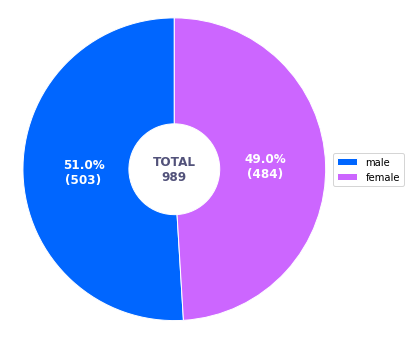

In [17]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [customers_segmentation[customers_segmentation['gender_name'] == 'Male']['gender_name'].count(),
         customers_segmentation[customers_segmentation['gender_name'] == 'Female']['gender_name'].count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(customers_segmentation['gender_id'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

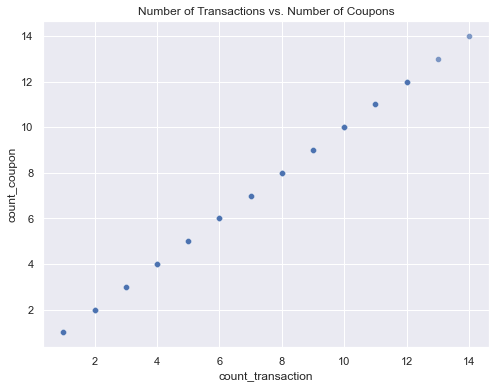

In [18]:
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=selected_features['count_transaction'], y=selected_features['count_coupon'], alpha=0.7)
plt.title('Number of Transactions vs. Number of Coupons')
plt.show()

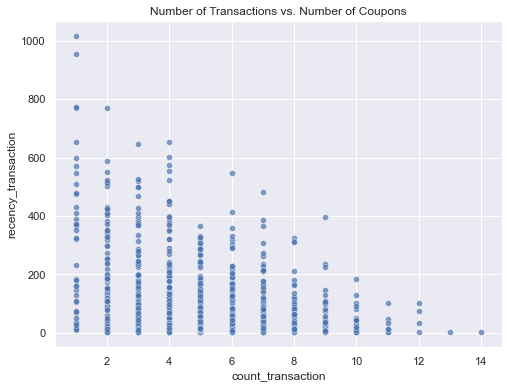

In [19]:
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=selected_features['count_transaction'], y=selected_features['recency_transaction'], alpha=0.7)
plt.title('Number of Transactions vs. Number of Coupons')
plt.show()

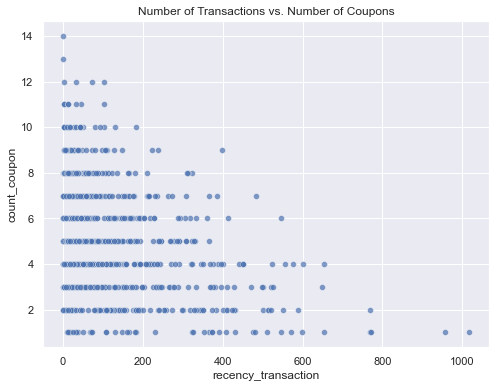

In [20]:
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=selected_features['recency_transaction'], y=selected_features['count_coupon'], alpha=0.7)
plt.title('Number of Transactions vs. Number of Coupons')
plt.show()

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [21]:
from itertools import product
from sklearn.metrics import silhouette_score

# Standardize the features
# scaler = StandardScaler()
# selected_features_scaled = scaler.fit_transform(selected_features)

# epsilon values to be investigated
epsilon = np.arange(14,20.25,0.25)
# minPoints values to be investigated
minPoints = np.arange(8,21) 

# 'product' function to make all possible combinations between epsilon and minPoints
DBSCAN_params = list(product(epsilon, minPoints))

# Create two empty lists to append number of clusters and silhouette scores to them, respectively
no_of_clusters = []
sil_score = []

# Iterate all the compination of DBSCAN produced by the 'product' function
for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(selected_features)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(selected_features, DBS_clustering.labels_))

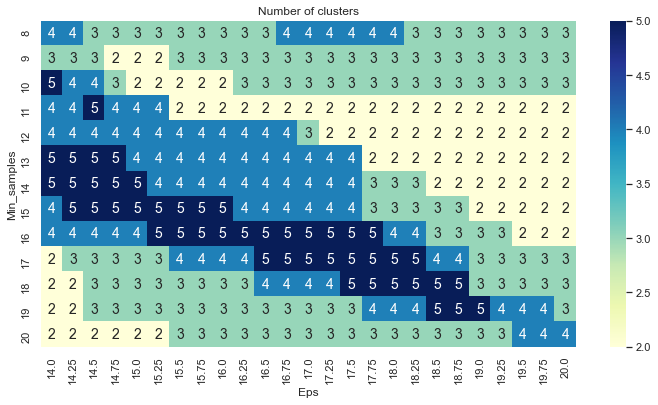

In [22]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 14}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

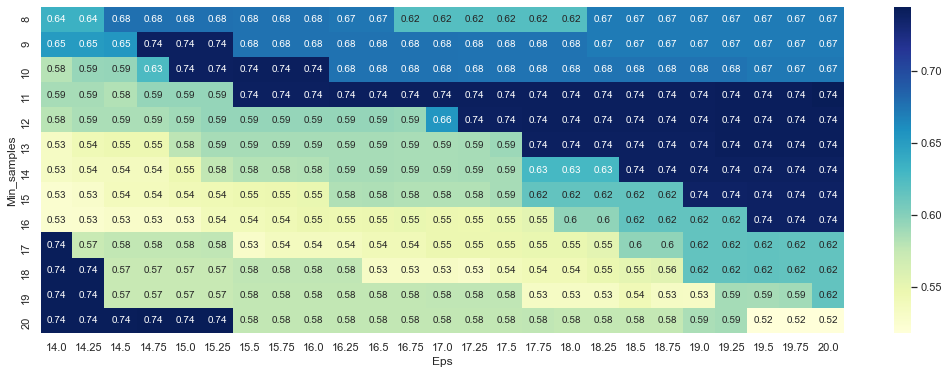

In [23]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [24]:
DBS_clustering = DBSCAN(eps=14.5, min_samples=8).fit(selected_features)

DBSCAN_clustered = selected_features.copy()
DBSCAN_clustered.loc[:,'cluster'] = DBS_clustering.labels_ # append labels to points

DBSCAN_clust_sizes = DBSCAN_clustered.groupby('cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["cluster_size"]
DBSCAN_clust_sizes

cluster_size
cluster              
-1                 32
 0                949
 1                  8

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


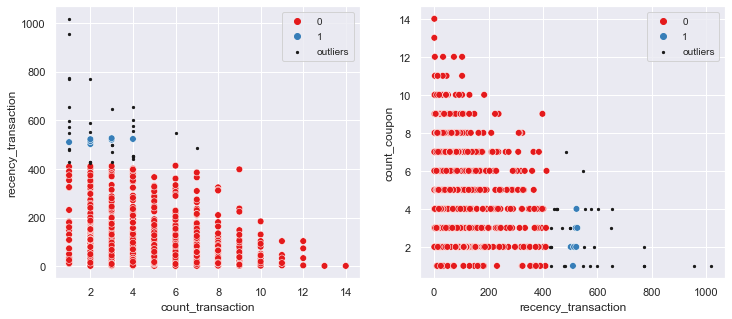

In [25]:
outliers = DBSCAN_clustered[DBSCAN_clustered['cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('count_transaction', 'recency_transaction',
                data=DBSCAN_clustered[DBSCAN_clustered['cluster']!=-1],
                hue='cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('recency_transaction', 'count_coupon',
                data=DBSCAN_clustered[DBSCAN_clustered['cluster']!=-1],
                hue='cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['count_transaction'], outliers['recency_transaction'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['recency_transaction'], outliers['count_coupon'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

## K-Means

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

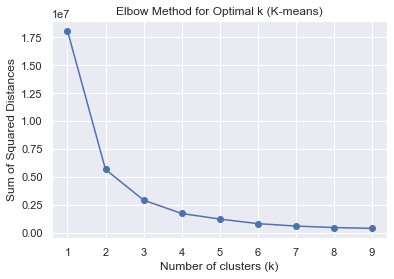

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Initialize a list to store sum of squared distances (inertia) for each k
sse = []

# Evaluate K-means performance for different k values
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(selected_features)

    # Append the sum of squared distances to the list
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k (K-means)')
plt.show()

In [27]:
from sklearn.cluster import KMeans

# Create feature matrix
X = selected_features

# Initialize the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add the predicted labels to the DataFrame
X['cluster'] = kmeans.labels_

# Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    X,
    x='count_transaction',
    y='count_coupon',
    z='recency_transaction',
    color='count_transaction',
    symbol='cluster',
    size_max=10,
    opacity=0.7,
    title='Interactive 3D Scatter Plot',
    labels={'count_transaction': 'count transaction', 'count_coupon': 'count coupon',
            'recency_transaction': 'recency transaction'}
)

# Show the interactive plot
fig.show()

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-27-7f0ea53417dc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


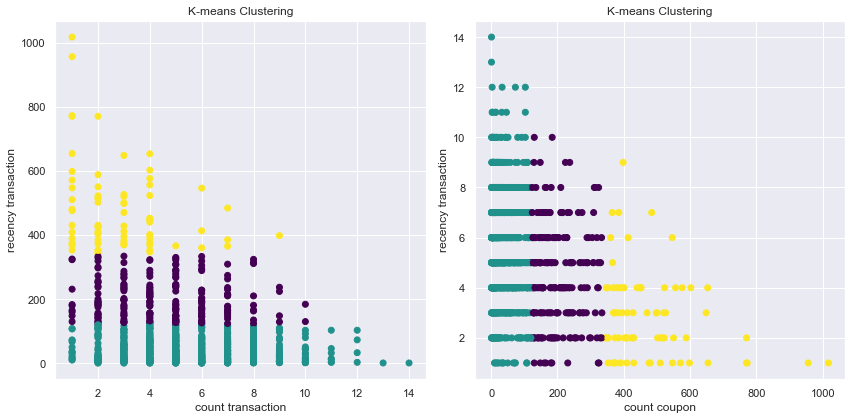

In [28]:
# Visualize the clusters on a scatter plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X['count_transaction'], X['recency_transaction'], c=X['cluster'], cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('count transaction')
plt.ylabel('recency transaction')

plt.subplot(1, 2, 2)
plt.scatter(X['recency_transaction'], X['count_coupon'], c=X['cluster'], cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('count coupon')
plt.ylabel('recency transaction')

plt.tight_layout()
plt.show()

In [29]:
# Calculate the silhouette score
score = silhouette_score(selected_features, X['cluster'])

print("Silhouette Score:", score)

Silhouette Score: 0.6597703811197083


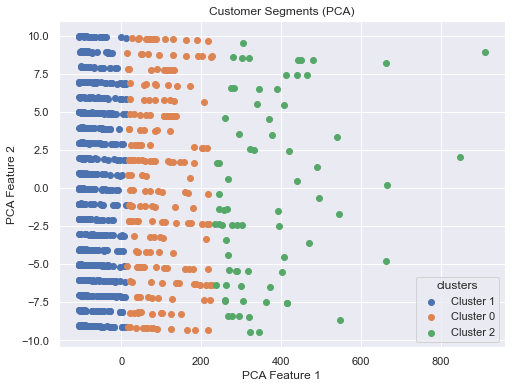

In [30]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(X)

# Create  a scatter plot with legend
plt.figure(figsize=(8, 6))

# Plot each cluster separately with different labels
clusters = X['cluster'].unique() # Get unique clusters
colors = ['blue', 'green', 'orange'] # Define colors for each cluster

for cluster, color in zip(clusters, colors):
    cluster_points = pca_features[X['cluster'] == cluster] # Filter
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    
# Add title and labels
plt.title("Customer Segments (PCA)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

# Add legend to the plot
plt.legend(title='clusters')

# Display the plot
plt.show()

#### - cluster 0: The most active and loyal customers whome should be given more coupons and offers for their loyality.  
#### - cluster 1: Lower transaction than cluster 0 customers and more recency from the last purchase. They could be given some       offers to encourage them for making more transactions.  
#### - cluster 2: The lowest customers in transactions with more recency in transactons periods. They could be given offers to increase thier transaction.